# Multi-point flux approximation (MPFA)

Porepy supports mpfa discretization for darcy flow problem:
\begin{equation}
q = -K \nabla p,\quad \nabla \cdot q = f
\end{equation}

We can write this as a single equation of pressure:
\begin{equation}
-\nabla \cdot K\nabla  p = f
\end{equation}

For each control volume $\Omega_k$ we then have
\begin{equation}
\int_{\Omega_k} f dv = \int_{\partial\Omega_k} (K\nabla p)\cdot n dA,
\end{equation}



To solve this system we first have to create the grid. Then we need to define boundary conditions. We set the bottom boundary as a Dirichlet boundary. The other boundaries are set to Neuman. We also need to create the permeability tensor:

In [1]:
import numpy as np
import porepy as pp

# Create grid
n = 5
g = pp.CartGrid([n,n])
g.compute_geometry()

# Define boundary type
dirich = np.ravel(np.argwhere(g.face_centers[1] < 1e-10))
bound = pp.BoundaryCondition(g, dirich, ['dir']*dirich.size)

# Create permeability matrix
k = np.ones(g.num_cells)
perm = pp.SecondOrderTensor(g.dim, k)

We now define the boundary conditions. We set zero pressure on the bottom boundary, and a constant innflow on the top boundary. Note that the traction on the Neumann boundary is the discharge, not the flux. To get the discharge for each boundary face we scale the flux by the face areas.

In [2]:
top_faces = np.ravel(np.argwhere(g.face_centers[1] > n - 1e-10))
bot_faces = np.ravel(np.argwhere(g.face_centers[1] < 1e-10))

p_b = np.zeros(g.num_faces)
p_b[top_faces] = 1 * g.face_areas[top_faces]
p_b[bot_faces] = 0


We can now solv this problem using the Mpfa class. We assume no source or sinks $f=0$:

In [5]:
mpfa_solver = pp.Mpfa("flow")

f = np.zeros(g.num_cells)

specified_parameters = {"permeability": perm, "source": f, "bc": bound, "bc_values": p_b}
data = pp.params.data.initialize_data({}, g, "flow", specified_parameters)

A, b = mpfa_solver.assemble_matrix_rhs(g, data)

p_class = np.linalg.solve(A.A, b)

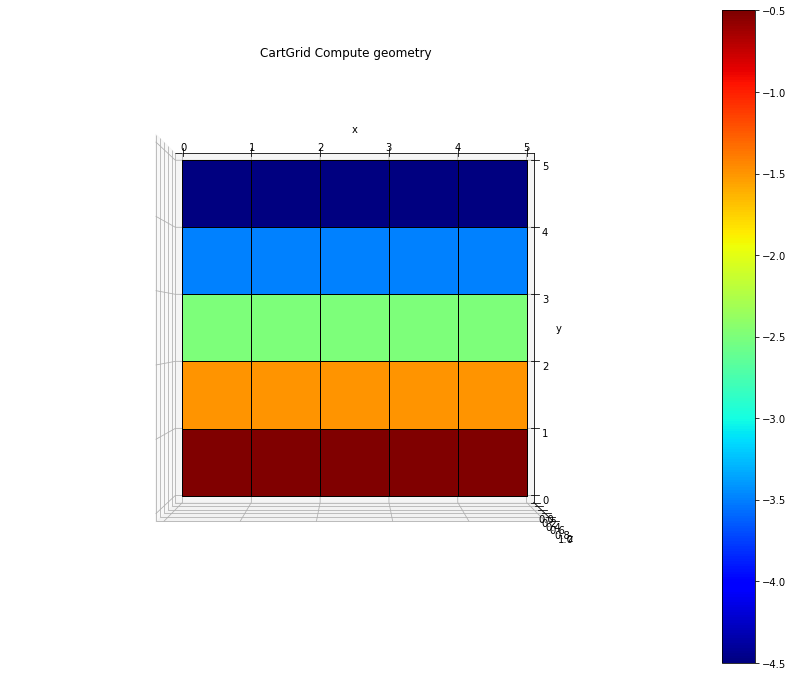

In [6]:
pp.plot_grid(g, cell_value=p_class, figsize=(15, 12))

To understand what goes on under the hood of the Mpfa class, we can also create the lhs and rhs manually. 

We start by discretizing the fluxes by using the multi-point stress approximation

In [9]:
flux, bound_flux, _, _ = mpfa_solver.mpfa(g, perm, bound)

mpfa returns the two sparse matrices "flux" and "bound_flux". They give  the discretization of the fluxes over each face:
\begin{equation}
F = \text{flux} \cdot p + \text{bound_flux} \cdot p_b
\end{equation}
Here $p$ is a vector of cell center pressure and has length g.num_cells. The vector $p_b$ is the boundary condition values. It is the pressure for Dirichlet boundaries and flux for Neumann boundaries and has length g.num_faces.


We are now ready to set up the linear system of equations and solve it. We assume no source and sinks $f = 0$. Each row in the discretized system is now
\begin{equation}
\int_{\Omega_k} f dv = \int_{\partial\Omega_k} F dA = [div \cdot \text{flux} \cdot p + div\cdot\text{bound_flux}\cdot p_b]_k,
\end{equation}
We move the known boundary variable $u_b$ over to the right hand side and solve the system:


In [10]:
div = pp.fvutils.scalar_divergence(g)
A = div * flux
b = f - div * bound_flux * p_b

p = np.linalg.solve(A.A, b)

This gives us the save results as using the Mpfa class:


In [11]:
assert np.allclose(p, p_class)

We can also plot the pressure

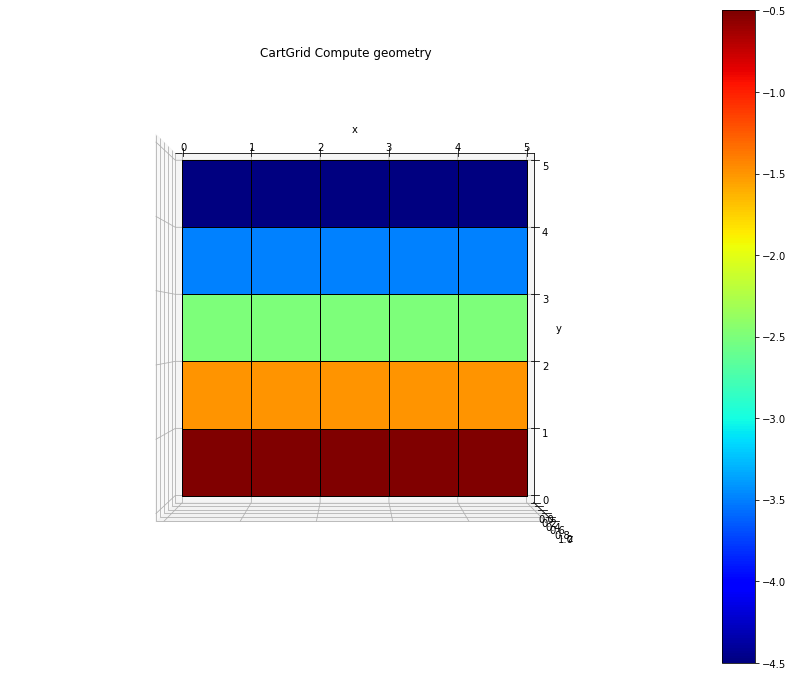

In [12]:
pp.plot_grid(g, cell_value=p, figsize=(15, 12))

We can also retrieve the flux for each face. 

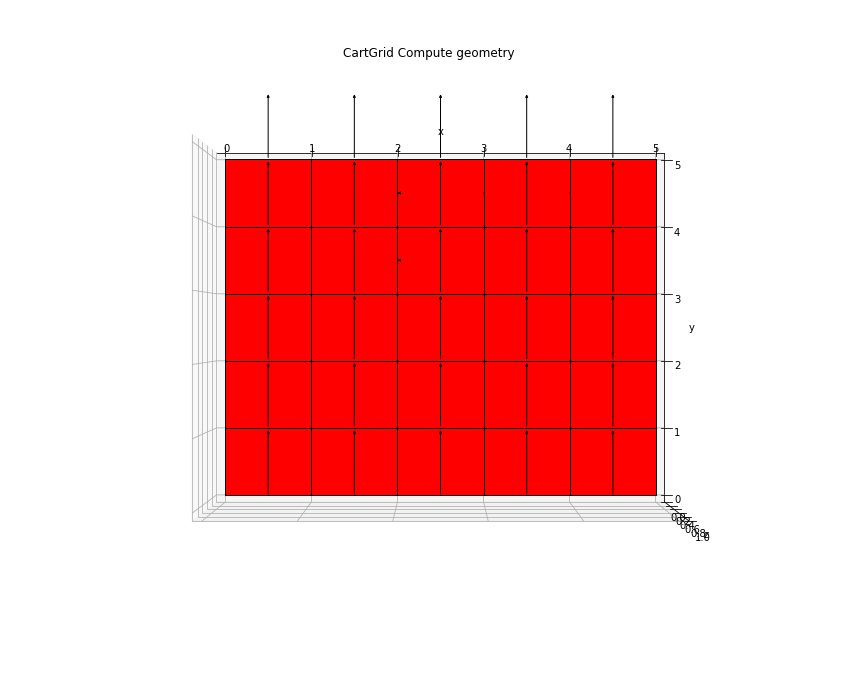

In [16]:
F = flux * p + bound_flux * p_b

neumann_faces = np.argwhere(bound.is_neu)

assert np.allclose(np.abs(p_b[neumann_faces]), np.abs(F[neumann_faces]))

F_n = F * g.face_normals
pp.plot_grid(g, vector_value=F_n, figsize=(15, 12))